# Importing libraries #

In [ ]:
import os
import numpy as np
import ncempy as nc
import matplotlib.pyplot as plt
import math
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter
import csv
import tifffile

# Function to find the radial profile by rotational  averaging #

In [ ]:
def rotational_average(image, center):
    x, y = np.indices(image.shape)
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)
    tbin = np.bincount(r.ravel(), image.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

# Function to find the baseline based on Asymmetric least squares smoothing (ALS) method #

In [ ]:
def als_baseline(spectrum, lam=1e5, p=0.001, niter=10):
    L = len(spectrum)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*spectrum)
        w = p * (spectrum > z) + (1-p) * (spectrum < z)
    return z

# Function to find the baseline based on piecewise Asymmetric least squares smoothing (ALS) method #

In [ ]:
def piecewise_als_baseline(y, lam=1e5, p=0.001, niter=10, window_length=350, overlap=100):
    y = np.array(y, dtype=float)
    
    # Handle case where signal is shorter than window
    if len(y) < window_length:
        return als_baseline(y, lam, p, niter)
    
    # Calculate number of windows needed
    n_windows = int(np.ceil((len(y) - overlap) / (window_length - overlap)))
    
    # Initialize baseline array
    baseline = np.zeros_like(y)
    weights = np.zeros_like(y)
    
    # Process each window
    for i in range(n_windows):
        # Calculate window indices
        start = i * (window_length - overlap)
        end = min(start + window_length, len(y))
        
        # Get window data
        y_window = y[start:end]
        
        # Calculate baseline for window
        baseline_window = als_baseline(y_window, lam, p, niter)
        
        # Create weighting for window (linear fade at edges)
        weight_window = np.ones_like(y_window)
        if i > 0:  # Left edge
            weight_window[:overlap] = np.linspace(0, 1, overlap)
        if i < n_windows - 1:  # Right edge
            weight_window[-overlap:] = np.linspace(1, 0, overlap)
            
        # Add to total baseline and weights
        baseline[start:end] += baseline_window * weight_window
        weights[start:end] += weight_window
    
    # Normalize by weights
    baseline /= weights
    
    return baseline

# Now we will use these functions to get time evolution plot of SAED patterns #

# If your input data are dm files #

In [ ]:
path = "/Volumes/Swarnendu/dp_image.dm4"
data = nc.io.dm.dmReader(path) # contains the metadata like pixel size

{'filename': 'image.dm4',
 'data': array([[ -2.0332513, -13.014811 , -10.037389 , ...,  19.422955 ,
          11.210634 ,  15.316793 ],
        [-15.000781 ,   6.6833663,   7.4413934, ...,  -4.7470117,
          14.165787 ,   4.709388 ],
        [  5.811553 ,  -5.1475153,  19.311977 , ...,   7.8457184,
           9.160509 ,   8.503113 ],
        ...,
        [  7.5894485,   7.7045274,  15.145203 , ...,   7.2382975,
          21.249386 ,  14.243841 ],
        [ -3.741005 ,  -3.33479  ,  -3.908339 , ...,   4.149192 ,
           4.856101 ,   4.502647 ],
        [-10.388339 , -32.533566 , -20.004553 , ...,  30.211721 ,
          33.38862  ,  31.80017  ]], dtype=float32),
 'pixelUnit': ['1/nm', '1/nm'],
 'pixelSize': [0.010375772, 0.010375772],
 'coords': [array([0.00000e+00, 1.04000e-02, 2.08000e-02, ..., 2.12185e+01,
         2.12288e+01, 2.12392e+01]),
  array([0.00000e+00, 1.04000e-02, 2.08000e-02, ..., 2.12185e+01,
         2.12288e+01, 2.12392e+01])]}

In [ ]:
with nc.io.dm.fileDM(path) as dm_file:
    image = dm_file.getDataset(0)['data']

# If your input data are tiff files #

In [ ]:
path = "/Volumes/Swarnendu/dp_image.tif"
image = tifffile.imread(path)

# Plot the image #

In [ ]:
fig, ax = plt.subplots()

# Plot the data
im = ax.imshow(image, cmap = 'binary')

plt.show()

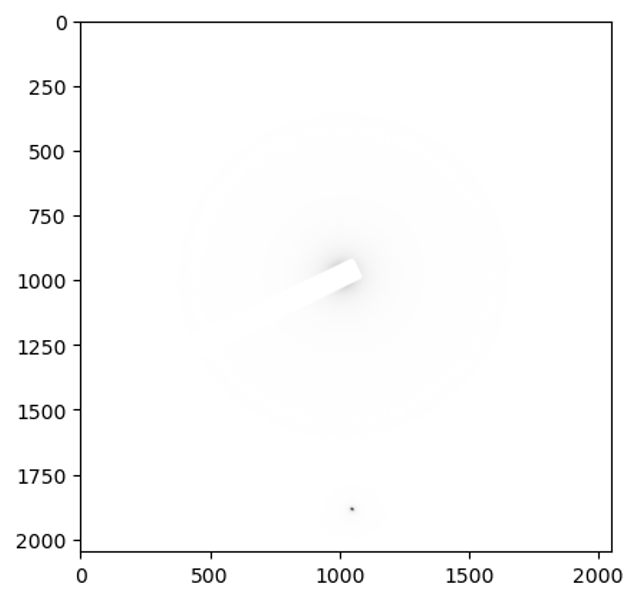

# Perform rotational averaging to get the radial profile and then ALS (or piecewise ALS, as needed) baseline subtraction #

In [ ]:
center = [972, 1018]
radial = rotational_average(image, center)
background_als = als_baseline(radial)
radial_als_corrected = radial - background_als

In [ ]:
plt.plot(radial)
plt.plot(background_als)
plt.plot(radial_als_corrected)

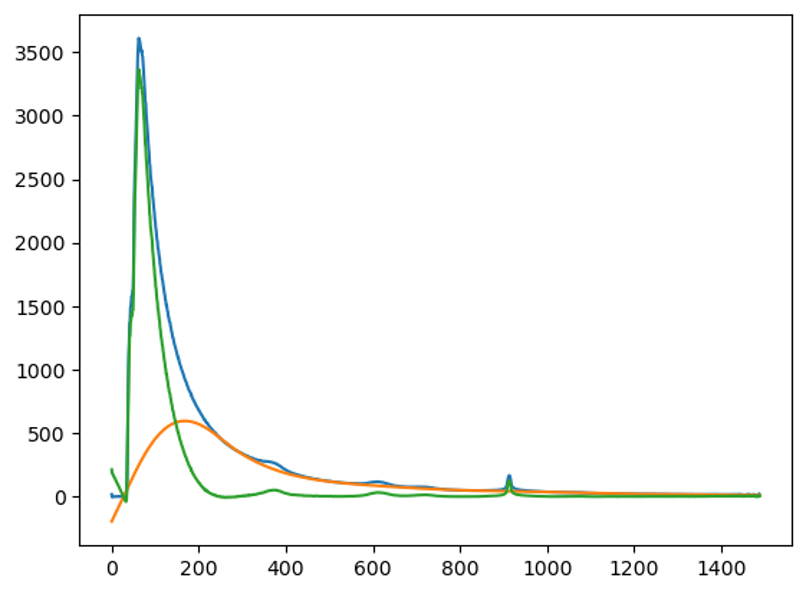

# We can perform the above steps on in-situ dataset to get time evolution of SAED patterns #

In [ ]:
folder_path = '/Volumes/Swarnendu/In-situ dataset images'

# Get a list of all dm4 files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.dm4')]
map = []

for file in file_list:
    file_path = os.path.join(folder_path, file)
    # Open the .dm4 file
    with nc.io.dm.fileDM(file_path) as dm_file:
        data = dm_file.getDataset(0)['data']
        # Perform rotational average
        center = [972, 1018]
        radial = rotational_average(data, center)
        background_als = als_baseline(radial)
        radial_als_corrected = radial - background_als
        map.append(radial_als_corrected[290:780]) # cropping the radial profile and storing

In [ ]:
x_axis = np.arange(0,491,80)
x_label = [math.trunc(i*(6.079/611)*100)/100 for i in range(290,781,80)] # calibrating x-axis

y_axis = np.arange(0,3263,250)
y_label = [i*0.04*5 for i in range(0,3263,250)] # calibrating y-axis

fig, ax = plt.subplots(figsize = (10, 6))

# Plot the data
im = ax.imshow(map, cmap = 'gnuplot_r', aspect='0.2')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Intensity', rotation = 90)

ax.set_xticks(x_axis, x_label, rotation = 0)
ax.set_yticks(y_axis[::-1], y_label[::-1])
ax.invert_yaxis()
ax.set_xlabel('q (nm$^{-1}$)')
ax.set_ylabel('Time (s)')

plt.show()

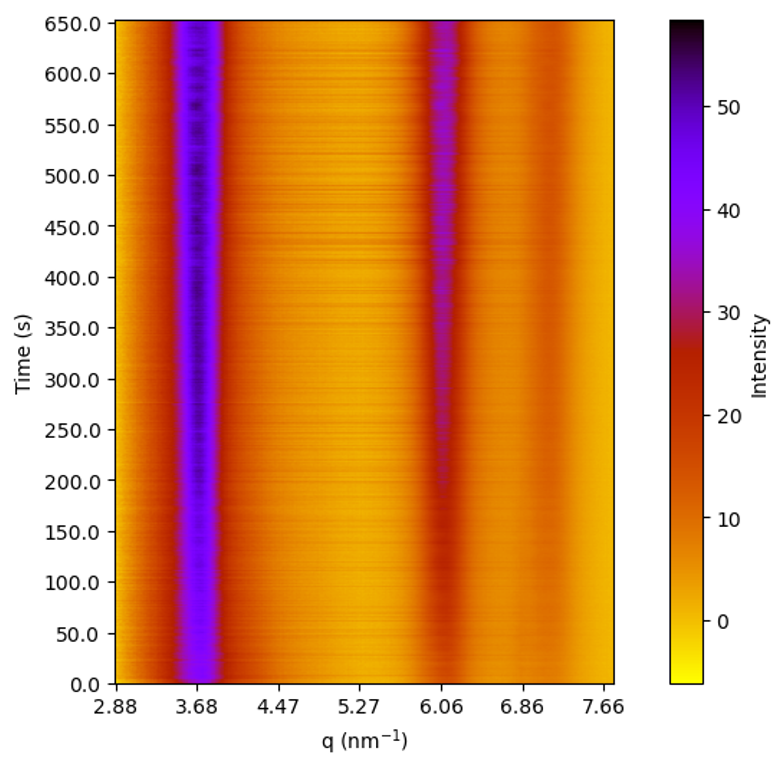

# Save the output list to a CSV file #

In [ ]:
with open('radial.csv', 'w', newline = '') as f:
    writer = csv.writer(f)
    for i in radial:
        writer.writerow([i])

In [ ]:
with open('map.csv', 'w', newline = '') as f:
    writer = csv.writer(f)
    writer.writerows(map)

# Load the list from the CSV file #

In [ ]:
with open('map.csv', 'r', newline = '') as f:
    reader = csv.reader(f, quoting = csv.QUOTE_NONNUMERIC)
    map = list(reader)